In [178]:
from IPython.display import HTML
HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    The raw code for this IPython notebook is by default hidden for easier reading.
    To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Document similarity
## 0. Splitting, tokenization, normalization.
Splitting: 
1. using regex to split the class bio into seperate files
2. store in q1/split

In [33]:
import codecs
f = codecs.open('q0/classbios_unicode.txt','r', encoding = 'utf-8', errors = 'replace')
text = f.read()
text = text.encode('ascii','replace')
# remove all the lines with "<== ... ==>"
import re
files = text.split("==> ")
file_list = []
i = 0
for bio in files:
    sp = bio.split(" <==")
    name = sp[0]
    try:
        if name != "?":
            file_list.append({name: sp[1]})
            open( 'q0/split/'+ str(i) + '. ' + name + '.txt', "w").write(sp[1])
            i += 1
    except IndexError:
        continue
        

Tokenization and normalization: 
1. using java (lucence standard tokenizer and english analyzer), java class: NormalizeBio.java
2. stored in q1/norm

Stopwords removing:
1. using python
2. stored in q1/filter

In [34]:
from nltk.corpus import stopwords
import os
stopword = stopwords.words('english')
for filename in os.listdir('q0/norm/'):
    with open('q0/norm/'+filename, 'r') as f:
        content = f.read().split()
        filt = [word for word in content if word not in stopword]
        open('q0/filter/'+filename, "w").write(' '.join(filt))

## 1. Boolean Similarity
1. read in vocabulary in q0/filter document by document, stored into a list
2. for each document, set the intersect to 1, set the rest to 0

In [107]:
import pandas as pd
voc = []
for filename in os.listdir('q0/filter/'):
    with open('q0/filter/' + filename, 'r') as f:
        if filename=='.DS_Store':
            continue
        voc += f.read().split()

voc_set = list(set(voc))
file_list = []
filename_list = []
for filename in os.listdir('q0/filter/'):
    with open('q0/filter/' + filename, 'r') as f:
        if filename=='.DS_Store':
            continue
        # set a word dictionary for f
        word_dict = dict.fromkeys(voc_set, 0)
        # counter
        for word in f.read().split():
            if word_dict[word]==0:
                word_dict[word]=1
        # transform into series
        word_series = pd.Series(word_dict, name=filename)
        file_list.append(word_series)
        
# concatenate series into dataframe
term_doc_matrix = pd.concat(file_list, axis = 1)
term_doc_matrix = term_doc_matrix.reindex_axis(sorted(term_doc_matrix.columns,
                                                      key=lambda string: int(string.split(".")[0])), 
                                               axis=1)

boolean similarity calculation

In [126]:
from numpy import linalg as LA
def sim(series1, series2):
    norm1, norm2 = LA.norm(series1), LA.norm(series2)
    dot_prod = series1.dot(series2)
    return round(dot_prod/(norm1*norm2),2)

calculate boolean similiarity matrix

In [109]:
import numpy as np
n = len(term_doc_matrix.columns)
bool_sim_mat = np.zeros([n,n])
for i in range(n):
    for j in range(i,n):
        bool_sim_mat[i, j] = sim(term_doc_matrix.ix[:,i], term_doc_matrix.ix[:,j])
for i in range(n):
    for j in range(i):
        bool_sim_mat[i, j] = bool_sim_mat[j, i]
np.savetxt('q1/boolean.txt', bool_sim_mat, fmt='%.2f')

In [110]:
def find_n_max(matrix, n):
    M = 200000
    top3 = [-M]*n
    top3_ind = [(-1,-1)]*n
    n, m = matrix.shape[0], matrix.shape[1]
    for i in range(n):
        for j in range(i):
            if matrix[i,j] > min(top3):
                ind = top3.index(min(top3))
                top3[ind] = matrix[i,j]
                top3_ind[ind] = (i,j)
    return zip(top3, top3_ind)
def find_n_min(matrix, n):
    M = 200000
    bottom3 = [M]*n
    bottom3_ind = [(-1,-1)]*n
    n, m = matrix.shape[0], matrix.shape[1]
    for i in range(n):
        for j in range(i):
            if matrix[i,j] < max(bottom3):
                ind = bottom3.index(max(bottom3))
                bottom3[ind] = matrix[i,j]
                bottom3_ind[ind] = (i,j)
    return zip(bottom3, bottom3_ind)

So finding the largest and smallest 3 number in the boolean similiarity matrix, the results are:


In [111]:
top, bottom = find_n_max(bool_sim_mat, 4), find_n_min(bool_sim_mat, 4)
top, bottom

([(0.33000000000000002, (27, 14)),
  (0.33000000000000002, (14, 7)),
  (0.33000000000000002, (34, 23)),
  (0.33000000000000002, (35, 6))],
 [(0.070000000000000007, (33, 8)),
  (0.11, (33, 18)),
  (0.11, (18, 1)),
  (0.10000000000000001, (15, 10))])

### TOP 3(4)
Translating into people's names
because these 4 pairs have same boolean similiarity, they are the "top 3 pair":

In [112]:
names = term_doc_matrix.columns
for pair in top:
    print names[pair[1][0]], names[pair[1][1]]

27. Kate Overstreet.txt 14. Mengshan Jin.txt
14. Mengshan Jin.txt 7. Mingyan Fan.txt
34. Apurvaa Subramaniam.txt 23. Melissa McNeill.txt
35. Brian Trent.txt 6. Alyssa Everding.txt


### BOTTOM 3(4)

In [113]:
bottom = sorted(bottom, key = lambda pair: pair[0])
for pair in bottom:
    print names[pair[1][0]], names[pair[1][1]]

33. Alexander Stec.txt 8. Theodore Feder.txt
15. Li Kan.txt 10. Jessica Feuston.txt
33. Alexander Stec.txt 18. Yilei Li.txt
18. Yilei Li.txt 1. Edward Binkley.txt


## 2. tf-idf Similiarity
1. make a tf-idf matrix
2. calculate similiarity matrix
3. get top 3/bottom 3

In [115]:
def count_doc(row):
    counter = 0
    for doc in row:
        if doc>0:
            counter+=1
    return counter

In [116]:
import pandas as pd
voc = []
for filename in os.listdir('q0/filter/'):
    with open('q0/filter/' + filename, 'r') as f:
        if filename=='.DS_Store':
            continue
        voc += f.read().split()

voc_set = list(set(voc))
voc_dict = dict.fromkeys(voc_set, 0)
file_list = []
for filename in os.listdir('q0/filter/'):
    with open('q0/filter/' + filename, 'r') as f:
        if filename=='.DS_Store':
            continue
        # set a word dictionary for f
        word_dict = dict.fromkeys(voc_set, 0)
        # counter
        for word in f.read().split():
            word_dict[word]+=1
            voc
        # transform into series
        word_series = pd.Series(word_dict, name=filename)
        file_list.append(word_series)
        
# tf of every doc, term pair:
term_doc_matrix = pd.concat(file_list, axis = 1)
term_doc_matrix = term_doc_matrix.reindex_axis(sorted(term_doc_matrix.columns,
                                                      key=lambda string: int(string.split(".")[0])), 
                                               axis=1)
# number of documents:
N = len(term_doc_matrix.columns)

# number of voc:
m = len(voc_set)

# df of all the terms
df_list = list(term_doc_matrix.apply(count_doc, axis=1))

In [128]:
term_doc_mat = term_doc_matrix.as_matrix()
term_doc_tfidf = np.zeros([m, N])

for i in range(m):
    for j in range(N):
        if term_doc_mat[i, j]==0:
            term_doc_tfidf[i, j]=0
        else:
            term_doc_tfidf[i, j] = (1+math.log(term_doc_mat[i, j]))*math.log(N/df_list[i])
#np.savetxt('q2/term_doc_tfidf.txt',term_doc_tfidf, fmt='%.2f')
term_doc_tfidf = pd.DataFrame(term_doc_tfidf)

In [131]:
import numpy as np
tfidf_sim_mat = np.zeros([N,N])
for i in range(N):
    for j in range(i,N):
        tfidf_sim_mat[i, j] = sim(term_doc_tfidf.ix[:,i], term_doc_tfidf.ix[:,j])
for i in range(n):
    for j in range(i):
        tfidf_sim_mat[i, j] = tfidf_sim_mat[j, i]
np.savetxt('q2/tf_idf.txt', tfidf_sim_mat, fmt='%.2f')

So finding the largest and smallest 3 number in the boolean similiarity matrix, the results are:

In [139]:
top, bottom = find_n_max(tfidf_sim_mat, 3), find_n_min(tfidf_sim_mat, 3)
top, bottom

([(0.11, (17, 7)), (0.12, (15, 2)), (0.11, (20, 7))],
 [(0.0, (15, 10)), (0.01, (3, 0)), (0.01, (5, 0))])

### TOP 3

In [141]:
names = term_doc_matrix.columns
top = sorted(top, key = lambda pair: -pair[0])
for pair in top:
    print names[pair[1][0]], names[pair[1][1]]

15. Li Kan.txt 2. Daniel Breitbach.txt
17. Yungjen Kung.txt 7. Mingyan Fan.txt
20. Eric Lundquist.txt 7. Mingyan Fan.txt


### BOTTOM 3

In [142]:
bottom = sorted(bottom, key = lambda pair: pair[0])
for pair in bottom:
    print names[pair[1][0]], names[pair[1][1]]

15. Li Kan.txt 10. Jessica Feuston.txt
3. Valentinos Constantinou.txt 0. Kapil Vinay Bhatt.txt
5. Yunyan Duan.txt 0. Kapil Vinay Bhatt.txt


# Indexing and retrieval
## 3. Indexing
1. download webpages(in Python) with urllib to request url, beautiful soup to read in contents
2. creating Lucene index; add name and text as fields (in java) source file is in: *"/Users/Rene/Documents/msia/16 Fall/text/hw 3/LuceneFirstApplication/src/com/tutorialspoint/lucene"*, main function is LuceneTester.java

In [47]:
# constants
wikiprefix = "https://en.wikipedia.org"
two_cap_country = ['State of Palestine', 'Sahrawi Arab Democratic Republic', 'Malaysia', 'Swaziland', 'Montserrat',
                  'Montenegro', 'Benin', 'Sri Lanka', 'Bolivia', 'Georgia', "Côte d'Ivoire"]
three_cap_country = ['South Africa']

In [ ]:
import urllib
f = urllib.urlopen("https://en.wikipedia.org/wiki/List_of_national_capitals_in_alphabetical_order")
from bs4 import BeautifulSoup
soup = BeautifulSoup(f.read())
index_page = soup.find_all("table")[2].find_all("tr")[1:]

cc_list = []
for country in index_page:
    if len(country.find_all("a"))>2 and country.find_all("a")[2].contents[0] in two_cap_country:
        e1 = {'city_name': country.find_all("a")[0].contents[0], 
             'city_href': wikiprefix + country.find_all("a")[0]['href'], 
             'country_name': country.find_all("a")[2].contents[0], 
             'country_href': wikiprefix + country.find_all("a")[2]['href']}
        cc_list.append(e1)
        e2 = {'city_name': country.find_all("a")[1].contents[0], 
             'city_href': wikiprefix + country.find_all("a")[1]['href'], 
             'country_name': country.find_all("a")[2].contents[0], 
             'country_href': wikiprefix + country.find_all("a")[2]['href']}
        cc_list.append(e2)
    elif len(country.find_all("a"))>3 and country.find_all("a")[3].contents[0] in three_cap_country:
        e1 = {'city_name': country.find_all("a")[0].contents[0], 
             'city_href': wikiprefix + country.find_all("a")[0]['href'], 
             'country_name': country.find_all("a")[3].contents[0], 
             'country_href': wikiprefix + country.find_all("a")[3]['href']}
        cc_list.append(e1)
        e2 = {'city_name': country.find_all("a")[1].contents[0], 
             'city_href': wikiprefix + country.find_all("a")[1]['href'], 
             'country_name': country.find_all("a")[3].contents[0], 
             'country_href': wikiprefix + country.find_all("a")[3]['href']}
        cc_list.append(e2)
        e3 = {'city_name': country.find_all("a")[2].contents[0], 
             'city_href': wikiprefix + country.find_all("a")[2]['href'], 
             'country_name': country.find_all("a")[3].contents[0], 
             'country_href': wikiprefix + country.find_all("a")[3]['href']}
        cc_list.append(e3)
    else:
        e = {'city_name': country.find_all("a")[0].contents[0], 
             'city_href': wikiprefix + country.find_all("a")[0]['href'], 
             'country_name': country.find_all("a")[1].contents[0], 
             'country_href': wikiprefix + country.find_all("a")[1]['href']}
        cc_list.append(e)

In [62]:
def read_text(link, tag_id):
    f = urllib.urlopen(link)
    soup = BeautifulSoup(f.read())
    #print link
    return soup.find(id = tag_id).text
#read_text("https://en.wikipedia.org/wiki/Alofi", "mw-content-text")

In [ ]:
import json
i = 0

for country in cc_list:
    info = {'city_name': country['city_name'], 
            'country_name': country['country_name'],
            'city_text': read_text(country['city_href'], "mw-content-text"),
            'country_text': read_text(country['country_href'], "mw-content-text")}
    with open('/Users/Rene/Documents/msia/16 Fall/text/hw 3/q3/Data/' + str(i)+'. '+ info['city_name'] +'.json', 'w') as fp:
        json.dump(info, fp)
    i+=1

## 4. Retrieval

Java code in */Users/Rene/Documents/msia/16 Fall/text/hw 3/LuceneFirstApplication/src/com/tutorialspoint/lucene/queryer*
### ‘Greek’ and ‘Roman’ but not ‘Persian’: 
Use a BooleanQuery for this. In addition to the Lucene docs, you might find this page a useful reference.

In [72]:
with open('/Users/Rene/Documents/msia/16 Fall/text/hw 3/q4/booleanQuery.txt') as f:
    for line in f.readlines():
        print(line)

Tripoli

Tunis

Sukhumi

Nicosia

Nicosia

Tiraspol

Monaco

Lisbon

Ramallah

Bucharest

Cairo

Sofia

Ljubljana

Tirana

Budapest

Bangui

Montevideo

Skopje

Belgrade

Algiers

Madrid

Bern

Berlin

Gibraltar

Bratislava

Vilnius

Dublin

Amsterdam

Kiev

Warsaw

Wellington

Buenos Aires

Copenhagen

Havana



### ‘Shakespeare’
even if it’s misspelled: Use a FuzzyQuery for this.

In [71]:
with open('/Users/Rene/Documents/msia/16 Fall/text/hw 3/q4/fuzzyQuery.txt') as f:
    for line in f.readlines():
        print(line)

London

Prague

Cairo

Washington, D.C.



### the words ‘located below sea level’ near each other
Use a PhraseQuery with a slop factor of 10. In addition to the Lucene docs, you might find this page a useful reference.

In [73]:
with open('/Users/Rene/Documents/msia/16 Fall/text/hw 3/q4/phraseQuery.txt') as f:
    for line in f.readlines():
        print(line)

Baku



### an interesting query of your choice: 
all city containing "china" in their city text

In [74]:
with open('/Users/Rene/Documents/msia/16 Fall/text/hw 3/q4/myQuery.txt') as f:
    for line in f.readlines():
        print(line)

Beijing

Nanjing

Hong Kong

Taipei

Vientiane

Dushanbe

Bandar Seri Begawan

Singapore

Episkopi Cantonment

Bangkok

Phnom Penh

Pyongyang

Dili

Ulaanbaatar

Bishkek

Saipan

Kathmandu

Manila

Tashkent

Luanda

Ashgabat

Nouakchott

Putrajaya

Malé

Sri Jayawardenepura Kotte

Seoul

Lilongwe

Mogadishu

Manama

Muscat

Astana

Ramallah

Naypyidaw

Port Louis

Sana'a

Sukhumi

Tokyo

Port Vila

Kutaisi

Belmopan

Bissau

Nicosia

Nicosia

Hanoi

Islamabad

Kuwait City

Riyadh

Kampala

Port Moresby

Praia

San José

Suva

Havana

Jakarta

New Delhi

Baghdad

Kabul

Abu Dhabi

Ankara

Tehran

Thimphu

Beirut

Cairo

Damascus

Doha

Amman

Castries

Bamako

Addis Ababa

Kuala Lumpur

Montevideo

Budapest

Canberra

Paramaribo

Hagåtña

Jerusalem

Lisbon

Prague

Baku

Dhaka

Lomé

Lusaka

Ouagadougou

Papeete

Roseau

São Tomé

St. George's

Brazzaville

Conakry

Antananarivo

Minsk

Riga

Algiers

Guatemala City

Khartoum

Nassau

Nuuk

Rabat

Buenos Aires

Nairobi



## 5. LDA
1. use java to create a term-docment-freq list (in *'/Users/Rene/Documents/msia/16 Fall/text/hw 3/LuceneFirstApplication/src/com/tutorialspoint/lucene/LDA.java'*)
2. read into python and pivot the table into matrix
3. run lda with lda library

In [2]:
import pandas as pd
termDoc = pd.read_csv('/Users/Rene/Documents/msia/16 Fall/text/hw 3/q5/termDoc.txt', header = None, 
                      delimiter = '|')
termDoc.columns = ['doc', 'term', 'freq']

In [3]:
termDoc1 = termDoc.drop_duplicates(subset = ['doc','term'])

### filtering terms that are english word, removing digit and special marks

In [14]:
import re
pattern = '[^\W\d]'
#termDoc2 = termDoc1[re.search(pattern, termDoc1['term'], flags = re.IGNORECASE) is not None]
#termDoc1.filter([1], regex = pattern, axis = 0)
termDoc2_1 = termDoc1[termDoc1['term'].str.contains(r'^[a-zA-Z0-9?><;,{}[\]\-_+=!@#$%\^&*|\']*$', 
                                                    flags=re.IGNORECASE, regex=True, na=False)]
termDoc2 = termDoc1[termDoc1['term'].str.contains(r'[^\W\d]', flags=re.IGNORECASE, regex=True, na=False)]
termDoc3 = termDoc2_1[~termDoc2_1['term'].str.contains(r'[_.\'0-9]', flags=re.IGNORECASE, regex=True, na=False)]

### Term Document Matrix:

In [115]:
term_doc_matrix = pd.pivot_table(termDoc3, index = 'term', columns = 'doc', values = 'freq', fill_value = 0)
#term_doc_matrix.to_csv('/Users/Rene/Documents/msia/16 Fall/text/hw 3/q5/termDoc_matrix.txt')

In [113]:
term_doc_matrix1 = term_doc_matrix.as_matrix().transpose()

In [18]:
import lda
import lda.datasets
import numpy as np

In [59]:
vocab = termDoc3['term'].unique().tolist()
title = termDoc3['doc'].unique().tolist()
model = lda.LDA(n_topics=50, n_iter=1000, random_state = 1)
model.fit(term_doc_matrix1)

<lda.lda.LDA instance at 0x1133b2e18>

### check model convergency

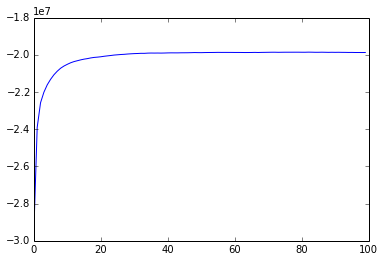

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
# skipping the first few entries makes the graph more readable
plt.plot(model.loglikelihoods_)

In [106]:
topic_word = model.topic_word_
n_top_words = 10
topics = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-n_top_words:-1]
    if not topics:
        topics = ['Topic {}: {}'.format(i, ' '.join(topic_words))]
    else:
        topics = topics + ['Topic {}: {}'.format(i, ' '.join(topic_words))]

In [114]:
doc_topic = model.doc_topic_
topic_map = {}
topic_map = topic_map.fromkeys(range(50))
for i in range(len(title)):
    topic = doc_topic[i].argmax()
    if topic_map[topic] is None:
        topic_map[topic] = [title[i]]
    else:
        topic_map[topic].append(title[i])
    #print("{} (top topic: {})".format(title[i], topic))

### Top 10 frequent topics

In [112]:
import operator
topic_len = {}
topic_len = topic_len.fromkeys(range(50))
for key in topic_len.keys():
    if topic_map[key] is not None:
        topic_len[key] = len(topic_map[key])
    else:
        topic_len[key] = 0
top10_topic_number = sorted(topic_len.iteritems(), key=operator.itemgetter(1), reverse=True)[:10]
top10_topic = [topics[topic_num[0]] for topic_num in top10_topic_number]
top10_topic

['Topic 0: otomi seringat chamanga pannonhalma hormouz rai sarnia terror pase',
 'Topic 22: comercio sarnia ofek irreligi sukhothai pujehun isaf upeneu bertold',
 'Topic 10: impos sept immin sephardim sopemi lic hemmerl dispersi domenichini',
 'Topic 38: comercio valpovo breadfield perciv wrai aka jaga koisan erkend',
 'Topic 45: lic concacaf poper meighoo valpovo uliss comercio ratliff kra',
 'Topic 49: comercio perciv zisser centru codi valpovo biosystem ovenston highschool',
 'Topic 1: bugti hydrocarbon seringat ministerstvem hormouz door sombolac kosmin vitacress',
 'Topic 18: guang machu angelokastro hertslet immin izabrao rove gct impos',
 'Topic 37: poper snif alchemi essi chilembw residu tavira meighoo wikisourc',
 'Topic 19: kurmi charca nass kherdba nunaminer arirang macouba chibchan posit']